<a href="https://colab.research.google.com/github/lcmolteberg/Machineoblig3/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3


In [1]:
!pip install pytorch-ignite

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import EarlyStopping
from copy import deepcopy
import torch.nn.functional as F
import torchvision.models as tvmodels
from sklearn.model_selection import StratifiedShuffleSplit


In [4]:
# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Exercise-1: Training Deep Neural Network on MNIST

In [5]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
train_set = datasets.MNIST("./data", train=True, transform=tfm, download=True)
test_set = datasets.MNIST("./data", train=False, transform=tfm, download=True)

# 1000 train and 200 test
n_train = 1000
n_test = 200

train_subset = Subset(train_set, np.arange(n_train))
test_subset = Subset(test_set, np.arange(n_test))

idx = train_subset.indices  # dette er np.arange(n_train)
print(len(idx), idx[:5], idx[-5:])

val_size = 200
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)


batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)


100%|██████████| 9.91M/9.91M [00:00<00:00, 61.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.79MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]

1000 [0 1 2 3 4] [995 996 997 998 999]


In [6]:
# Model

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNN().to(device)


Epoch 01: Train 2.9424 | Val 0.8568
Epoch 02: Train 1.9906 | Val 0.6026
Epoch 03: Train 1.3151 | Val 0.5422
Epoch 04: Train 0.8638 | Val 0.5029
Epoch 05: Train 0.5643 | Val 0.5408
Epoch 06: Train 0.3660 | Val 0.5163
Epoch 07: Train 0.2369 | Val 0.5215
Epoch 08: Train 0.1534 | Val 0.5276


2025-11-05 00:16:21,658 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 09: Train 0.0999 | Val 0.5326
Restored best weights (val_loss=0.5029)


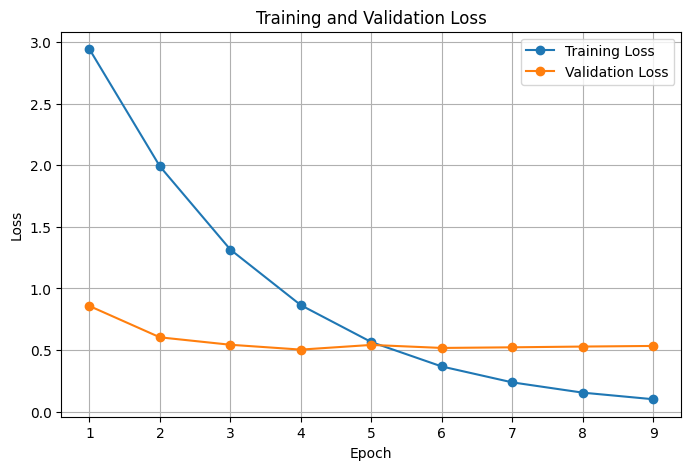

In [7]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# --- EarlyStopping: høyere score = bedre, så returner -val_loss ---
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Viktig: kobles til EVALUATOR, og evaluator MÅ kjøres hver epoke
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# --- historikk for plotting ---
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss fra RunningAverage ELLER beregn selv – beholder du din nåværende måte, bruk den
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Kjør validering (triggere EarlyStopping via evaluator-eventet)
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # (valgfritt) hvis du ikke bruker RunningAverage: mål train loss med en egen evaluator-pass
    # evaluator.run(train_eval_loader); train_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # ---- SAVE BEST IN MEMORY (restore best weights) ----
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# --- tren (ES kan stoppe før 50) ---
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# --- plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()


## Q 1.1

In [8]:
# --- test ---
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

Test set — loss: 0.4179, accuracy: 0.8750
Final Test Accuracy: 87.50%


# Exercise-2: Training Deep Neural Network on CIFAR-10


In [9]:
# Dataset

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)


tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])
train_set = datasets.CIFAR10("./data", train=True, transform=tfm, download=True)
test_set = datasets.CIFAR10("./data", train=False, transform=tfm, download=True)



# 1000 train and 200 test
n_train = 5000
n_test = 1000

train_subset = Subset(train_set, np.arange(n_train))
test_subset = Subset(test_set, np.arange(n_test))

idx = train_subset.indices  # dette er np.arange(n_train)
print(len(idx), idx[:5], idx[-5:])

val_size = 1000
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)

100%|██████████| 170M/170M [00:07<00:00, 22.6MB/s]


5000 [0 1 2 3 4] [4995 4996 4997 4998 4999]


In [10]:
# Model

class DNNCI(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNNCI().to(device)

Epoch 01: Train 3.2116 | Val 2.4847
Epoch 02: Train 2.4684 | Val 2.2728
Epoch 03: Train 1.8962 | Val 2.1536
Epoch 04: Train 1.4487 | Val 2.0648
Epoch 05: Train 1.1004 | Val 2.1897
Epoch 06: Train 0.8346 | Val 2.3933
Epoch 07: Train 0.6204 | Val 2.8097
Epoch 08: Train 0.5028 | Val 2.8401


2025-11-05 00:16:56,287 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 09: Train 0.3622 | Val 2.8736
Restored best weights (val_loss=2.0648)


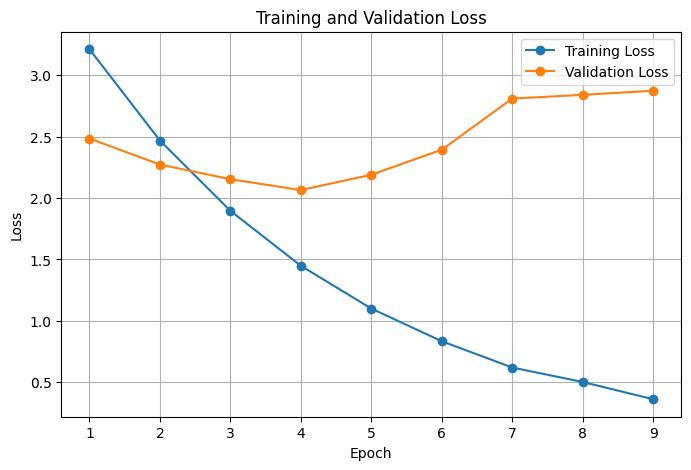

In [11]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# --- EarlyStopping: høyere score = bedre, så returner -val_loss ---
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Viktig: kobles til EVALUATOR, og evaluator MÅ kjøres hver epoke
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# --- historikk for plotting ---
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss fra RunningAverage ELLER beregn selv – beholder du din nåværende måte, bruk den
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Kjør validering (triggere EarlyStopping via evaluator-eventet)
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # (valgfritt) hvis du ikke bruker RunningAverage: mål train loss med en egen evaluator-pass
    # evaluator.run(train_eval_loader); train_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # ---- SAVE BEST IN MEMORY (restore best weights) ----
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# --- tren (ES kan stoppe før 50) ---
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# --- plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()


## Q 2.1

In [12]:

# --- test ---
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

2025-11-05 00:16:57,059 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Test set — loss: 2.2277, accuracy: 0.3390
Final Test Accuracy: 33.90%


# Exercise-3: Regularization with Alpha Dropout and MC Dropout

In [13]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307), std=(0.3081))
])

full_train = datasets.MNIST("./data", train=True, transform=tfm, download=True)
full_test = datasets.MNIST("./data", train=False, transform=tfm, download=True)

n_train = 1000
n_test = 200

train_subset = Subset(full_train, np.arange(n_train))
test_subset = Subset(full_test, np.arange(n_test))

val_size = 200
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)



In [14]:
# Model

class DNN_ADMC(nn.Module):
  def __init__(self, p=0.1):
    super().__init__()
    self.flatten = nn.Flatten()
    self.net = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 10)
    )
    self._lecun_init()

  def _lecun_init(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    return self.net(self.flatten(x))

model = DNN_ADMC().to(device)


Epoch 01: Train 2.2285 | Val 0.7699
Epoch 02: Train 1.7144 | Val 0.6174
Epoch 03: Train 1.2952 | Val 0.5984
Epoch 04: Train 0.9801 | Val 0.5752
Epoch 05: Train 0.7532 | Val 0.5662
Epoch 06: Train 0.5971 | Val 0.6115
Epoch 07: Train 0.4692 | Val 0.6422
Epoch 08: Train 0.3794 | Val 0.6830
Epoch 09: Train 0.3065 | Val 0.7342
Epoch 10: Train 0.2586 | Val 0.7536
Epoch 11: Train 0.2250 | Val 0.7206
Epoch 12: Train 0.1889 | Val 0.7966
Epoch 13: Train 0.1617 | Val 0.8334
Epoch 14: Train 0.1430 | Val 0.8776
Epoch 15: Train 0.1305 | Val 0.8665
Epoch 16: Train 0.1128 | Val 0.8775
Epoch 17: Train 0.0965 | Val 0.8161
Epoch 18: Train 0.0799 | Val 0.8379
Epoch 19: Train 0.0763 | Val 0.8325
Epoch 20: Train 0.0715 | Val 0.8809
Epoch 21: Train 0.0639 | Val 0.9367
Epoch 22: Train 0.0669 | Val 0.9373
Epoch 23: Train 0.0640 | Val 0.9769
Epoch 24: Train 0.0581 | Val 0.9815
Epoch 25: Train 0.0498 | Val 0.9283
Epoch 26: Train 0.0495 | Val 0.9101
Epoch 27: Train 0.0514 | Val 1.0251
Epoch 28: Train 0.0395 | Val

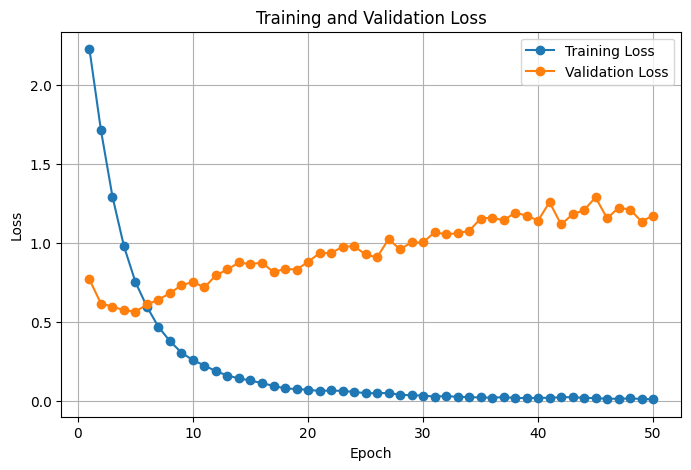

In [15]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(engine):
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)
    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")

trainer.run(train_loader, max_epochs=50)

plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()



## Q 3.1

In [16]:
# Test
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")

Test set — loss: 0.5498, accuracy: 0.9000
Final Test Accuracy: 90.00%


## Q 3.2

In [17]:
# MonteCarlo-dropout

def mc_dropout(model, loader, device, T=20):
    was_training = model.training
    model.train()

    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        B = x.size(0)
        x_rep = x.unsqueeze(0).expand(T, -1, -1, -1, -1).reshape(T*B, *x.shape[1:])
        logits = model(x_rep)
        probs = F.softmax(logits, dim=1).view(T, B, -1).mean(0)
        pred = probs.argmax(1)

        correct += (pred == y).sum().item()
        total += B
    if not was_training:
        model.eval()
    return correct / total

base_acc = m['accuracy']
mc_acc   = mc_dropout(model, test_loader, device, T=20)
print(f"Test (no MC): {base_acc*100:.2f}%")
print(f"MC-Dropout (T=20): {mc_acc*100:.2f}%")



Test (no MC): 90.00%
MC-Dropout (T=20): 89.00%


# Exercise-4: Transfer Learning with Pre-trained CNN

In [18]:
# Dataset

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)


tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

train_set = datasets.CIFAR10("./data", train=True, transform=tfm, download=True)
test_set = datasets.CIFAR10("./data", train=False, transform=tfm, download=True)

n_train = 2000
n_test = 500

labels = np.array(train_set.targets[:n_train])

splitter = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=seed)
train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))

train_subset = Subset(train_set, train_idx)
val_subset = Subset(train_set, val_idx)
test_subset = Subset(test_set, np.arange(n_test))


batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)

In [19]:
# Model

base_model = tvmodels.mobilenet_v2(weights=tvmodels.MobileNet_V2_Weights.IMAGENET1K_V2)
for p in base_model.features.parameters():
  p.requires_grad = False

base_model.features.eval()  # Sett alle lagene i features til eval-modus
for m in base_model.features.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

base_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)
model = base_model.to(device)



Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 81.7MB/s]


Epoch 01 | train 2.2088 | val 2.0066
Epoch 02 | train 1.9293 | val 1.8876
Epoch 03 | train 1.8454 | val 1.9109
Epoch 04 | train 1.7610 | val 1.8925
Epoch 05 | train 1.7463 | val 1.8417


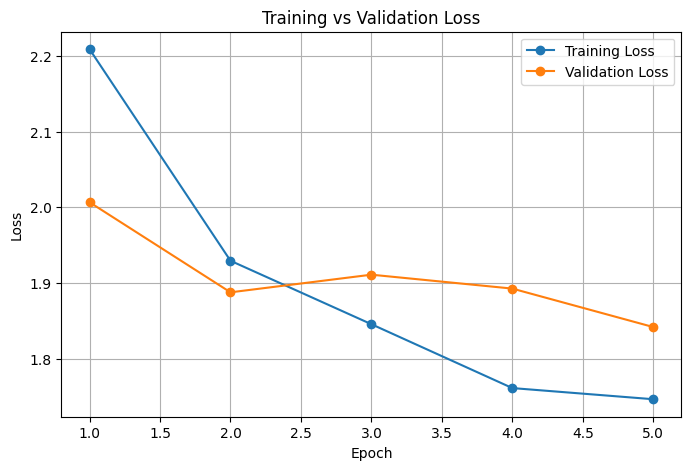

In [20]:
# Optimizer

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


def evaluate_acc_and_loss(model, loader, loss_fn, device):
    model.eval()
    total, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total += loss_fn(logits, y).item() * x.size(0)
        n += x.size(0)
    return total / n

def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item() * x.size(0)

        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)
        val_loss = evaluate_acc_and_loss(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

    plt.figure(figsize=(8,5))
    epochs = range(1, len(train_losses)+1)
    plt.plot(epochs, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss')
    plt.grid(True); plt.legend(); plt.show()

    return model, train_losses, val_losses

trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=5
)



## Q 4.1

In [21]:
# Test


def evaluate(model, loader, loss_fn, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        tot_loss += loss_fn(logits, y).item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss/total, correct/total

test_loss, test_acc = evaluate(trained_model, test_loader, loss_fn, device)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")


Test loss: 1.8693 | Test accuracy: 34.40%


# Exercise-5: Deeper CNN Training on SVHN

In [22]:
# Dataset

svhn_mean = [0.4377, 0.4438, 0.4728]
svhn_std = [0.1980, 0.2010, 0.1970]

# Transformasjonspipeline
tfm = transforms.Compose([
    transforms.ToTensor(),  # Konverterer bildet til Tensor
    transforms.Normalize(mean=svhn_mean, std=svhn_std)  # Normaliserer bildet med mean og std for SVHN
])
target_map = lambda y: 0 if int(y) == 10 else int(y)

train_set = datasets.SVHN("./data", split="train", transform=tfm,
                          target_transform=target_map, download=True)
test_set  = datasets.SVHN("./data", split="test", transform=tfm,
                          target_transform=target_map, download=True)

n_train = 2000
n_test = 500

train_idx = np.arange(0, 1600)
val_idx = np.arange(1600, 2000)
test_idx = np.arange(0, n_test)

train_subset = Subset(train_set, train_idx)
val_subset = Subset(train_set, val_idx)
test_subset = Subset(test_set, test_idx)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size, shuffle=False)


100%|██████████| 182M/182M [00:10<00:00, 17.3MB/s]
100%|██████████| 64.3M/64.3M [00:05<00:00, 12.4MB/s]


In [23]:
# Model

class SVHN_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*8*8, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

model = SVHN_CNN().to(device)



Epoch 01 | train 2.2376 | val 2.2468
Epoch 02 | train 2.2069 | val 2.1941
Epoch 03 | train 1.9204 | val 1.6710
Epoch 04 | train 1.3133 | val 1.2101
Epoch 05 | train 0.9029 | val 0.9602
Epoch 06 | train 0.7059 | val 0.8038
Epoch 07 | train 0.5454 | val 0.8457
Epoch 08 | train 0.4663 | val 0.8220
Epoch 09 | train 0.3543 | val 0.8195
Epoch 10 | train 0.3023 | val 0.9242
Epoch 11 | train 0.2302 | val 0.9920
Epoch 12 | train 0.1838 | val 1.1026
Epoch 13 | train 0.2191 | val 0.9028
Epoch 14 | train 0.1841 | val 1.0073
Epoch 15 | train 0.1449 | val 1.0805


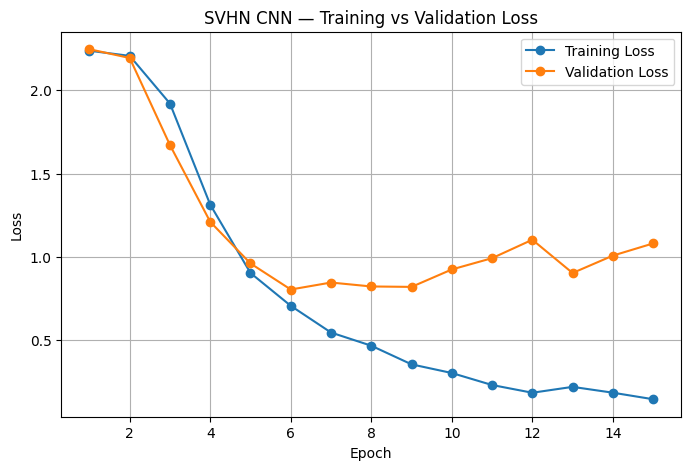

In [24]:
# Optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def evaluate_loss(model, loader):
    model.eval()
    total, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

def evaluate_acc(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

train_losses, val_losses = [], []

epochs = 15
for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)

    train_loss = running / len(train_loader.dataset)
    train_losses.append(train_loss)
    val_loss = evaluate_loss(model, val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('SVHN CNN — Training vs Validation Loss')
plt.grid(True); plt.legend(); plt.show()

## Q 5.1

In [25]:
test_loss = evaluate_loss(model, test_loader)
test_acc  = evaluate_acc(model, test_loader)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")


Test loss: 1.3399 | Test accuracy: 76.60%


# Exercise-6: CNN with SGD, MC Dropout, and Epistemic Uncertainty

In [26]:
# Dataset

svhn_mean = [0.4377, 0.4438, 0.4728]
svhn_std = [0.1980, 0.2010, 0.1970]

# Transformasjonspipeline
tfm = transforms.Compose([
    transforms.ToTensor(),  # Konverterer bildet til Tensor
    transforms.Normalize(mean=svhn_mean, std=svhn_std)
])
target_map = lambda y: 0 if int(y) == 10 else int(y)

train_set = datasets.SVHN("./data", split='train', transform=tfm, target_transform=target_map, download=True)
test_set = datasets.SVHN("./data", split='test', transform=tfm, target_transform=target_map, download=True)

n_train_total = 2000
n_test = 500
train_idx = np.arange(0, 1600)
val_idx   = np.arange(1600, 2000)
test_idx  = np.arange(0, n_test)

train_subset = Subset(train_set, train_idx)
val_subset   = Subset(train_set, val_idx)
test_subset  = Subset(test_set,  test_idx)

batch = 32
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
val_loader   = DataLoader(val_subset,   batch_size=batch,   shuffle=False)
test_loader  = DataLoader(test_subset,  batch_size=batch,   shuffle=False)


In [27]:
# Model

class SVHN_SGD_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SVHN_SGD_CNN().to(device)

Epoch 01 | train 2.2409 | val 2.2557
Epoch 02 | train 2.2098 | val 2.2340
Epoch 03 | train 2.1667 | val 2.1816
Epoch 04 | train 2.0226 | val 1.9795
Epoch 05 | train 1.6655 | val 1.5501
Epoch 06 | train 1.2804 | val 1.3436
Epoch 07 | train 1.0140 | val 1.1561
Epoch 08 | train 0.8424 | val 0.8823
Epoch 09 | train 0.6487 | val 0.9124
Epoch 10 | train 0.5297 | val 0.9044
Epoch 11 | train 0.4760 | val 0.9839
Epoch 12 | train 0.4113 | val 1.0181
Epoch 13 | train 0.3596 | val 0.9184
Epoch 14 | train 0.2623 | val 0.9306
Epoch 15 | train 0.2284 | val 0.8773


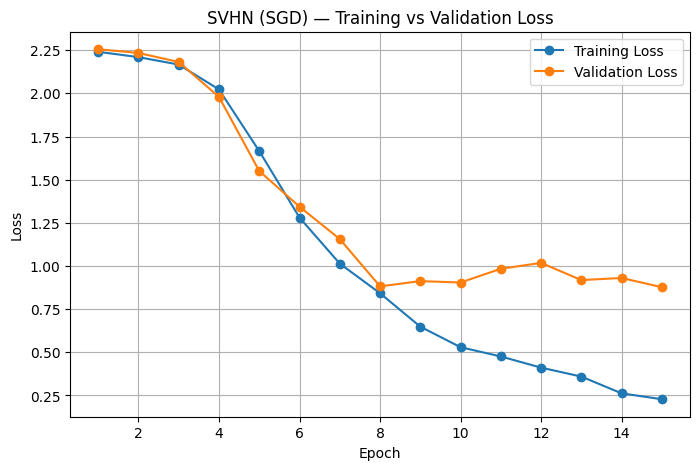

In [28]:
# Optimizer

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

def evaluate_loss(model, loader):
  model.eval()
  total, n = 0.0, 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    total += loss_fn(model(x), y).item() * x.size(0)
    n += x.size(0)
  return total / n

def evaluate_acc(model, loader):
  model.eval()
  correct, total = 0, 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    pred = model(x).argmax(1)
    correct += (pred == y).sum().item()
    total += y.size(0)
  return correct / total


epochs= 15
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
  model.train()
  running = 0.0
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits = model(x)
    loss = loss_fn(logits, y)
    loss.backward()
    optimizer.step()
    running += loss.item() * x.size(0)

  train_loss = running / len(train_loader.dataset)
  train_losses.append(train_loss)
  val_loss = evaluate_loss(model, val_loader)
  val_losses.append(val_loss)
  print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('SVHN (SGD) — Training vs Validation Loss')
plt.grid(True); plt.legend(); plt.show()

## Q 6.1

In [29]:
test_loss = evaluate_loss(model, test_loader)
test_acc  = evaluate_acc(model, test_loader)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")



Test loss: 1.1076 | Test accuracy: 75.20%


## Q 6.2

In [30]:
import torch
import torch.nn as nn
import numpy as np

# --- Aktiver bare Dropout under eval ---
def enable_dropout_only(module: nn.Module):
    for m in module.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout1d, nn.Dropout2d, nn.Dropout3d)):
            m.train()  # kun dropout i train-modus

@torch.no_grad()
def mc_dropout_eval(model: nn.Module, dataloader, T: int = 20, device: str = None):

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    enable_dropout_only(model)  # aktiver kun Dropout

    all_mean_probs, all_var_probs, all_targets = [], [], []

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)

        probs_T = []
        for _ in range(T):
            logits = model(xb)                 # [B, C]
            p = torch.softmax(logits, dim=1)   # sannsynligheter
            probs_T.append(p.unsqueeze(0))     # [1, B, C]

        probs_T = torch.cat(probs_T, dim=0)    # [T, B, C]
        mean_probs = probs_T.mean(dim=0)       # [B, C]
        var_probs  = probs_T.var(dim=0, unbiased=False)  # [B, C]

        all_mean_probs.append(mean_probs.cpu())
        all_var_probs.append(var_probs.cpu())
        all_targets.append(yb.cpu())

    mean_probs = torch.cat(all_mean_probs, dim=0)  # [N, C]
    var_probs  = torch.cat(all_var_probs,  dim=0)  # [N, C]
    targets    = torch.cat(all_targets,    dim=0)  # [N]

    preds = mean_probs.argmax(dim=1)
    mc_acc = (preds == targets).float().mean().item()

    # Per-sample epistemisk usikkerhet (skalar): gj.snitt varians over klasser
    epistemic_per_sample = var_probs.mean(dim=1).numpy()

    return mc_acc, epistemic_per_sample, mean_probs.numpy(), var_probs.numpy()

# ---- KJØR MC DROPOUT (T=20) PÅ TESTENE ----
T = 20
mc_acc, epistemic_per_sample, mean_probs, var_probs = mc_dropout_eval(
    model, test_loader, T=T, device=device
)

print(f"Q6.2 — MC Dropout (T={T}) accuracy: {mc_acc*100:.4f}%")

Q6.2 — MC Dropout (T=20) accuracy: 0.7480
Epistemisk usikkerhet (mean predictive variance over klasser): mean=0.006610, std=0.007831
Minst usikre idx/var: [(122, 1.0449970539984921e-16), (303, 3.0391833315059915e-16), (353, 1.9858691683541808e-15), (19, 2.667120191897159e-15), (323, 1.1904815139598696e-14)]
Mest  usikre idx/var: [(364, 0.03140263631939888), (379, 0.03319987654685974), (380, 0.03532666340470314), (133, 0.03897131606936455), (218, 0.04108665511012077)]


## Q 6.3

In [31]:
avg_epi = float(np.mean(epistemic_per_sample))
print(f"Q6.3 — Average epistemic uncertainty (mean predictive variance): {avg_epi:.3f}")

Q6.3 — Average epistemic uncertainty (mean predictive variance): 0.007
